In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

complaints_ratio_df = pd.read_csv('../data/complaints_with_response_ratio.csv', delimiter=',')
complaints_sentiment_df = pd.read_csv('../data/complaints_with_sentiment_score.csv', delimiter=',')

In [2]:
complaints_sentiment_df.replace({'Company response to consumer': {'Closed': 'Closed without explanation'}}, inplace= True)
complaints_sentiment_df = complaints_sentiment_df[complaints_sentiment_df['Company response to consumer'].isin(
    ['Closed with non-monetary relief',
    'Closed with monetary relief', 'Closed with explanation',
    'Closed without explanation', 'Untimely response'])]

In [3]:
print(complaints_ratio_df.shape)
print(complaints_sentiment_df.shape)

(485699, 12)
(485699, 20)


In [4]:
merged_df = pd.merge(complaints_ratio_df, complaints_sentiment_df[['Complaint ID', 'Narrative sentiment score']], on='Complaint ID')
merged_df = merged_df.drop('Unnamed: 0', 1)
merged_df

,Complaint ID,Product,Narrative,Company,State,Response,Closed with explanation,Closed with non-monetary relief,Closed with monetary relief,Closed without explanation,Untimely response,Narrative sentiment score
0,3315279,"Credit reporting, repair, or other",I have complained many times that the credit r...,Experian Information Solutions Inc.,CA,Closed with explanation,60.68,38.55,0.73,0.04,0.0,0.155694
1,3259329,"Credit reporting, repair, or other","According to the Fair Credit Reporting Act, Se...",Experian Information Solutions Inc.,HI,Closed with non-monetary relief,60.68,38.55,0.73,0.04,0.0,0.235102
2,3266929,"Credit reporting, repair, or other",EXPERIAN HAS SOME INFORMATION ON MY CREDIT REP...,Experian Information Solutions Inc.,FL,Closed with non-monetary relief,60.68,38.55,0.73,0.04,0.0,0.215753
3,3222896,"Credit reporting, repair, or other",Accounts added and/or created unbeknownst to m...,Experian Information Solutions Inc.,FL,Closed with non-monetary relief,60.68,38.55,0.73,0.04,0.0,0.473450
4,3289721,"Credit reporting, repair, or other",I do not own this debt and demand that you imm...,Experian Information Solutions Inc.,GA,Closed with explanation,60.68,38.55,0.73,0.04,0.0,0.462072
...,...,...,...,...,...,...,...,...,...,...,...,...
485694,2005685,Debt collection,"NorAm Capital Holdings, Inc. \ncollecting for ...","NorAm Capital Holdings, Inc.",CA,Closed without explanation,0.00,0.00,0.00,100.00,0.0,0.549215
485695,3038874,"Payday loan, title loan, or personal loan",fbi is involved and cc the matter- even thru f...,"3D Financial, LP",AZ,Closed with explanation,100.00,0.00,0.00,0.00,0.0,0.247246
485696,3073029,Mortgage,"Please See Attachments Based on my experience,...",Homes By Hunt LLC,LA,Closed with explanation,100.00,0.00,0.00,0.00,0.0,0.672983
485697,2365852,Money transfers,I send some money to XXXX through XXXX And my ...,Maxitransfers Corporation,GA,Closed with explanation,100.00,0.00,0.00,0.00,0.0,0.353015


### Zonder balancing

In [7]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

feature_names = ['Closed with explanation', 'Closed with non-monetary relief', 'Closed with monetary relief',
                'Closed without explanation', 'Untimely response', 'Narrative sentiment score']
X = merged_df[feature_names]
y = merged_df['Response']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(388559, 6)
(388559,)
(97140, 6)
(97140,)


In [8]:
model = SVC(gamma='scale')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [13]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names= merged_df['Response'].unique()))

                                 precision    recall  f1-score   support

        Closed with explanation       0.82      1.00      0.90     78482
Closed with non-monetary relief       0.58      0.02      0.04      5244
    Closed with monetary relief       0.74      0.06      0.10     12043
     Closed without explanation       0.85      0.08      0.14       720
              Untimely response       0.84      0.73      0.78       651

                       accuracy                           0.82     97140
                      macro avg       0.77      0.37      0.39     97140
                   weighted avg       0.80      0.82      0.75     97140



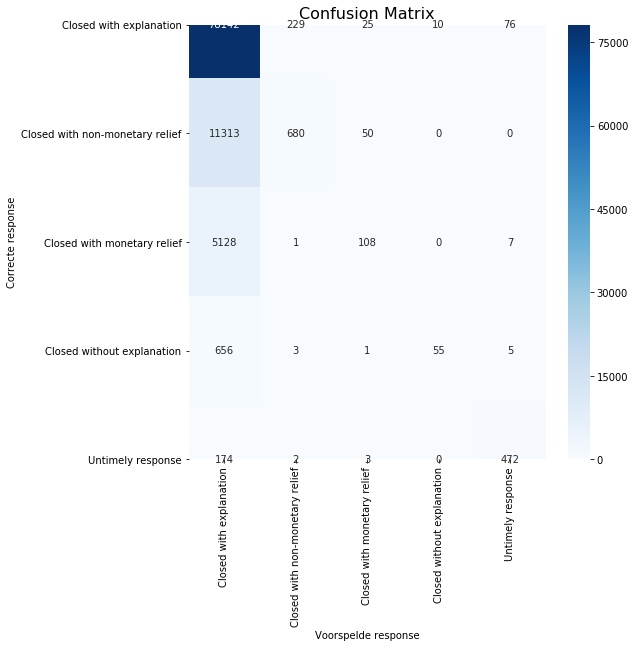

In [11]:
labels = ['Closed with explanation', 'Closed with non-monetary relief', 'Closed with monetary relief',
                'Closed without explanation', 'Untimely response']
conf_mat = confusion_matrix(y_test, y_pred, labels=labels)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d', xticklabels=labels, yticklabels=labels)
plt.ylabel('Correcte response')
plt.xlabel('Voorspelde response')
plt.title("Confusion Matrix", size=16);

### Met balancing

In [5]:
def sampling_k_elements(category, k=120000):
    if len(category) < k:
        return category
    return category.sample(k)

complaints_balanced_df = merged_df.groupby('Response').apply(sampling_k_elements).reset_index(drop=True)

In [14]:
complaints_balanced_df.shape

(213146, 12)

In [15]:
X_bal = complaints_balanced_df[feature_names]
y_bal = complaints_balanced_df['Response']
X_bal_train, X_bal_test, y_bal_train, y_bal_test = train_test_split(X_bal, y_bal, test_size=0.2)

print(X_bal_train.shape)
print(y_bal_train.shape)

print(X_bal_test.shape)
print(y_bal_test.shape)

(170516, 6)
(170516,)
(42630, 6)
(42630,)


In [16]:
model_bal = SVC(gamma='scale')
model_bal.fit(X_bal_train, y_bal_train)
y_bal_pred = model.predict(X_bal_test)

In [17]:
print(metrics.classification_report(y_bal_test, y_bal_pred, target_names= complaints_balanced_df['Response'].unique()))

                                 precision    recall  f1-score   support

        Closed with explanation       0.58      1.00      0.73     24032
    Closed with monetary relief       0.73      0.02      0.04      5213
Closed with non-monetary relief       0.89      0.06      0.11     11990
     Closed without explanation       0.95      0.08      0.15       751
              Untimely response       0.93      0.75      0.83       644

                       accuracy                           0.59     42630
                      macro avg       0.81      0.38      0.37     42630
                   weighted avg       0.70      0.59      0.46     42630



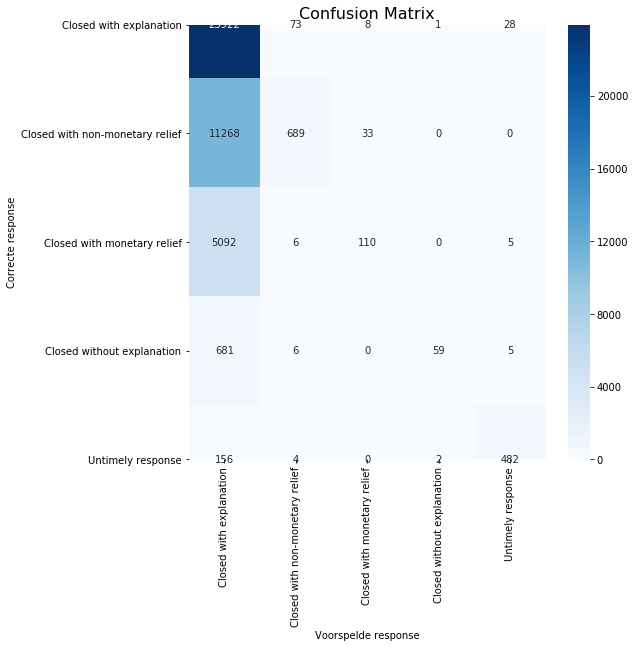

In [19]:
conf_mat_bal = confusion_matrix(y_bal_test, y_bal_pred, labels=labels)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat_bal, annot=True, cmap="Blues", fmt='d', xticklabels=labels, yticklabels=labels)
plt.ylabel('Correcte response')
plt.xlabel('Voorspelde response')
plt.title("Confusion Matrix", size=16);